In [ ]:
# The codes for the Flan model are written by Shijia, model pipeline adapted from the DeBERTa setup

In [ ]:
!pip install nltk
!pip install datasets
!pip install transformers[torch]
!pip install tokenizers
!pip install evaluate
!pip install accelerate -U
!pip install rouge_score
!pip install accelerate
!pip install sentencepiece
!pip install huggingface_hub
!pip install wandb

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import datasets

annotations = datasets.load_dataset("bigbio/sem_eval_2024_task_2", name="sem_eval_2024_task_2_source")
raw_texts = datasets.load_dataset("bigbio/sem_eval_2024_task_2", name="sem_eval_2024_task_2_ct")["train"]

In [ ]:
from datasets import concatenate_datasets, load_dataset, Dataset
import json

with open('/content/drive/MyDrive/biomedical/new_instances_UPDATED.json', 'r') as file:
     new_data = json.load(file)

reformat_new_data = {category:[] for category in ['id', 'type', 'section_id', 'primary_id', 'secondary_id', 'statement', 'label']}

for id, data in new_data.items():
  reformat_new_data ["id"].append(id)
  for category, content in data.items():
    if category.lower() == "subproblem": continue
    reformat_new_data[category.lower()].append(content)


new = Dataset.from_dict(reformat_new_data)

assert annotations["train"].features.type == new.features.type
new_train = concatenate_datasets([annotations["train"], new])
new_train

In [ ]:
max_input_length = 512
max_target_length = 8

def find_text_by_id(raw_texts, given_id, section):
    for item in raw_texts:
        if item["clinical_trial_id"] == given_id:
            return ' '.join(item[section])

def preprocess_function(examples, raw_texts=raw_texts): # examples are dataset, e.g: annotations["train"]
    # 'id', 'type', 'section_id', 'primary_id', 'secondary_id', 'statement', 'label'
    inputs = []

    for idx, statement in enumerate(examples['id']):

      section = examples["section_id"][idx].lower()
      if section == "adverse events": section = "adverse_events"

      input = "The context entails the statement, true or false? Context: primary CTR: " + find_text_by_id(raw_texts, examples['primary_id'][idx], section)
      if examples["type"][idx] == "Comparison":
        try:
          input += f" secondary CTR: " + find_text_by_id(raw_texts, examples['secondary_id'][idx], section)
        except:
          pass


      input += " Statement: " + examples["statement"][idx]
      inputs.append(input)

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    new_labels = ["true" if label == "Entailment" else "false" for label in examples["label"]] # transform "entailment" to "true"

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=new_labels, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["text"] = inputs

    return model_inputs

In [ ]:
train_dataset = new_train.map(preprocess_function, batched=True, remove_columns=['type','section_id', 'primary_id','secondary_id', 'statement', 'label']) # load_from_cache_file=False
eval_dataset = annotations["validation"].map(preprocess_function, batched=True, remove_columns=['type','section_id', 'primary_id','secondary_id', 'statement', 'label']) # load_from_cache_file=False

In [ ]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

data_collator = DataCollatorForSeq2Seq(tokenizer, padding=True)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

import nltk
import numpy as np

def compute_metrics(pred):
    t = "true"
    f = "false"

    correct = 0
    total = 0

    label_t = tokenizer(t, return_tensors="pt", padding=True)["input_ids"].to(device)
    label_f = tokenizer(f, return_tensors="pt", padding=True)["input_ids"].to(device)

    for input in eval_dataset:
        total += 1
        output = model.generate(input_ids=torch.tensor(input["input_ids"]).unsqueeze(0).to(device), max_new_tokens=8)

        output_t = model(output, labels=label_t)
        output_f = model(output, labels=label_f)

        logits_t = output_t.logits
        logits_f = output_f.logits

        loss_t = torch.nn.functional.cross_entropy(logits_t.view(-1, logits_t.size(-1)), label_t.view(-1))
        loss_f = torch.nn.functional.cross_entropy(logits_f.view(-1, logits_f.size(-1)), label_f.view(-1))

        if loss_t < loss_f:
            pre = 1176 # true
        else:
            pre = 6136 # false

        if input["labels"][0] == pre:
            correct += 1

    return {'accuracy': correct/total}

In [ ]:
import locale
import wandb

locale.getpreferredencoding = lambda: "UTF-8"
!huggingface-cli login --token    # please enter your login key
wandb.login(key="wandb_login_keys")          # please enter your login key

In [ ]:
from transformers import TrainerCallback
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import pickle

def inference_one_instance(text, model, tokenizer, device):
    """
    do inference on one instance
    """
    t = "true"
    f = "false"

    input = tokenizer(text, return_tensors="pt", padding=True).to(device)
    output = model.generate(input_ids=input["input_ids"], attention_mask= input["attention_mask"], max_new_tokens=8)
    label_t = tokenizer(t, return_tensors="pt", padding=True)["input_ids"].to(device)
    label_f = tokenizer(f, return_tensors="pt", padding=True)["input_ids"].to(device)

    output_t = model(output, labels=label_t)
    output_f = model(output, labels=label_f)

    logits_t = output_t.logits
    logits_f = output_f.logits

    loss_t = torch.nn.functional.cross_entropy(logits_t.view(-1, logits_t.size(-1)), label_t.view(-1))
    loss_f = torch.nn.functional.cross_entropy(logits_f.view(-1, logits_f.size(-1)), label_f.view(-1))

    softmax = torch.softmax(torch.tensor([loss_f, loss_t]), -1).tolist() # because it is loss, switch the order of True and False

    return softmax


class MyCallback(TrainerCallback):
    """
    MyCallback
    """
    result = dict()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # cls attribute

    def on_epoch_end(self, args, state, control, **kwargs):
        print('MyCallback')
        with torch.no_grad():
            for instance in train_dataset:
                instance_id = instance['id']
                text = instance['text']
                output = inference_one_instance(text, model, tokenizer, device)
                if instance_id in MyCallback.result.keys():
                    MyCallback.result[instance_id].append(output)
                else:
                    MyCallback.result[instance_id] = [output]
        with open('Flan_probability_list_new.pkl', 'wb') as file:
            pickle.dump(MyCallback.result, file)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

c = inference_one_instance("noodle", model, tokenizer, device)
a = tokenizer.encode_plus("true", return_tensors="pt", padding=True)
b = tokenizer("false", return_tensors="pt", padding=True).to(device)

output = model.generate(input_ids=b["input_ids"], attention_mask= b["attention_mask"], max_new_tokens=8)

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

batch_size = 16

args = Seq2SeqTrainingArguments(
    output_dir="./logs/run2/flan_biomedidal_new",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*4,
    gradient_accumulation_steps=2,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=1e-3,
    num_train_epochs=5,
    predict_with_generate=True,
    bf16=True if torch.cuda.is_available() else False,
    logging_strategy="steps",
    logging_steps=len(train_dataset)//batch_size,
    logging_dir='./logs',
    save_strategy="epoch",
    save_total_limit=1,
    dataloader_num_workers=2,
    load_best_model_at_end="True",
    push_to_hub=True,
    report_to="wandb"
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MyCallback]
)

In [ ]:
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

In [ ]:
torch.cuda.empty_cache()
trainer.train()
trainer.save_model("Flan_base_round1")
!wandb disabled
trainer.push_to_hub()

In [ ]:
torch.cuda.empty_cache()
trainer.train()
trainer.save_model("Flan_base_round1")
!wandb disabled
trainer.push_to_hub()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.341887,0.555000
2,0.376600,0.344370,0.550000
3,0.376600,0.337483,0.585000


MyCallback


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


MyCallback


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


MyCallback


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


MyCallback


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.341887,0.555000
2,0.376600,0.344370,0.550000
3,0.376600,0.337483,0.585000
4,0.367900,0.337644,0.575000
5,0.367900,0.337593,0.585000


MyCallback


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


W&B disabled.


CommitInfo(commit_url='https://huggingface.co/Shijia/flan_biomedidal_new/commit/253f1ddcb427b3ffeabcda2bff278badc64fffed', commit_message='End of training', commit_description='', oid='253f1ddcb427b3ffeabcda2bff278badc64fffed', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import matplotlib.pyplot as plt
import math
import pickle

In [ ]:
!cp /content/Flan_probability_list_new.pkl /content/drive/MyDrive/biomedical/Flan_probability_list_new2.pkl

{'00466f98-52b8-41f3-9bf1-2edaad950be9': 0.6608123540878296, '0046e113-8ac5-4725-a285-e78b8c26f825': 0.6943460404872894, '0057172f-d019-401b-a516-993a7b46a67b': 0.6699230194091796, '006f6b4e-6245-4f09-9786-327bbed3d766': 0.6963190793991089, '007de11b-4265-4695-b18e-e0d6909a347a': 0.6685477554798126, '0093175a-38cb-4f63-b391-709ac48158b8': 0.7030275046825409, '009d23bb-2179-4ce3-927d-4dedca6b32a8': 0.6898857235908509, '00dc0e37-1d0b-4f53-a037-86bf9799dae6': 0.6822884678840637, '011991a5-724d-4b95-b9ab-9e1371d77368': 0.7223558843135833, '01236718-14da-450c-8051-0207d31743a5': 0.6949863791465759, '01280892-ca31-4e46-831b-a076426f65e5': 0.7233229756355286, '0151d1fa-05c8-45a0-b21e-f08478ea5110': 0.6780627310276032, '0159bfb3-231e-4711-b3ee-2798c66f5f6a': 0.6955800533294678, '01a57096-0278-4c70-be43-acd57010cd6f': 0.684255051612854, '01b82c51-dd3d-430b-9523-0e93a9eb9c1a': 0.6980965852737426, '01c6f82e-710d-4fa4-aa62-2d26e72f4533': 0.688392835855484, '01dfa37b-ce65-4e90-addc-395241c92f5f': 0

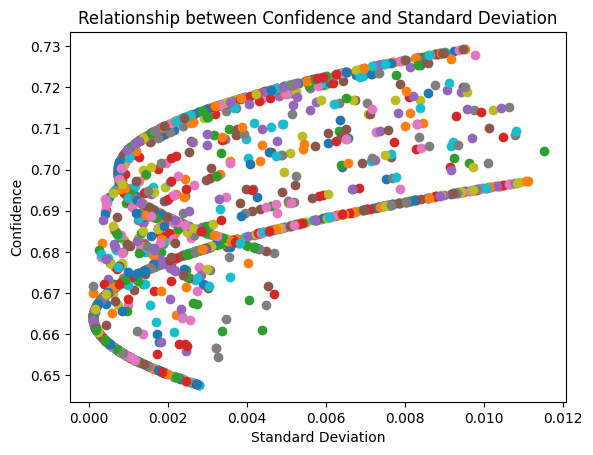

# Test dataset

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = T5Tokenizer.from_pretrained("Shijia/flan_biomedidal_new")
model = T5ForConditionalGeneration.from_pretrained("Shijia/flan_biomedidal_new").to(device)

In [ ]:
test_dataset = annotations["test"].map(preprocess_function, batched=True, remove_columns=['type','section_id', 'primary_id','secondary_id', 'statement', 'label'])

In [ ]:
import json

def test():
    t = "true"
    f = "false"

    correct = 0
    total = 0

    label_t = tokenizer(t, return_tensors="pt", padding=True)["input_ids"].to(device)
    label_f = tokenizer(f, return_tensors="pt", padding=True)["input_ids"].to(device)

    result_data = {}


    for input in test_dataset:
        total += 1
        output = model.generate(input_ids=torch.tensor(input["input_ids"]).unsqueeze(0).to(device), max_new_tokens=8)

        output_t = model(output, labels=label_t)
        output_f = model(output, labels=label_f)

        logits_t = output_t.logits
        logits_f = output_f.logits

        loss_t = torch.nn.functional.cross_entropy(logits_t.view(-1, logits_t.size(-1)), label_t.view(-1))
        loss_f = torch.nn.functional.cross_entropy(logits_f.view(-1, logits_f.size(-1)), label_f.view(-1))

        if loss_t < loss_f:
            pre = 1176 # true
            result_data[input["id"]] = {"Prediction": "Entailment"}

        else:
            pre = 6136 # false
            result_data[input["id"]] = {"Prediction": "Contradiction"}

    file_path = 'test_prediction.json'

    with open(file_path, "w") as json_file:
        json.dump(result_data, json_file)

    print(f"Result saved to {file_path}")

    return result_data

In [ ]:
result_data = test()